Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from sklearn.preprocessing import MinMaxScaler

Importing the training set

In [2]:
# Select relevant features (e.g., Open, High, Low, Close)
features = ['Open', 'High', 'Low', 'Close']  # Adjust as needed

# Load train data
train_data = pd.read_csv('GOOG_Train.csv')[features]
# Load test data
test_data = pd.read_csv('GOOG_Test.csv')[features]

Feature Scaling

In [3]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data)

Creating a data structure to store previos data also

In [4]:
# Define sequence length
sequence_length = 60

# Prepare data for LSTM model
X_train, y_train = [], []
for i in range(sequence_length, len(scaled_train_data)):
    X_train.append(scaled_train_data[i-sequence_length:i, :])
    # Choose the target value based on your prediction goal:
    # Option 1: Predict Open price at next time step
    # y_train.append(scaled_train_data[i, 0])  # Open price
    # Option 2: Predict all four features at next time step
    y_train.append(scaled_train_data[i, :])  # All four features

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape X_train for LSTM layer (add extra dimension for channels)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(features)))

Model building

In [5]:
# Build the LSTM model
model = models.Sequential()
model.add(layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], len(features))))
model.add(layers.LSTM(units=50))
# Option 1: Predict Open price
# model.add(Dense(units=1))  # Output layer for predicting Open price
# Option 2: Predict all four features
model.add(layers.Dense(units=4))  # Output layer for predicting all four features

# Compile the model
model.compile( optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)  # Adjust epochs and batch size

C:\Users\kgabani\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.2320 - loss: 0.0286
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.3370 - loss: 5.2545e-04
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.3133 - loss: 4.5837e-04
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.3339 - loss: 5.0036e-04
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.3573 - loss: 4.1159e-04
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.3315 - loss: 4.4693e-04
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.3656 - loss: 3.5256e-04
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.3391 - loss: 3.9677e-04
Epoch 9/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.3282 - loss: 3.2944e-04
Epoch 10/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.3234 - loss: 3.0859e-04
Epoch 11/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.3279 - loss: 3.2859e-04
Epoch 12/50
90/90 ━━━━━

In [6]:
# Save the trained model
model.save('stock_prediction_model.keras')

Test

In [7]:
# Load the saved model
model = models.load_model('stock_prediction_model.keras')

In [8]:
dataset_total = pd.concat((train_data, test_data), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test_data) - sequence_length:].values   # we need some data from training as well
scaled_test_data = scaler.transform(inputs)

# Prepare X_test for prediction
X_test = []
for i in range(sequence_length, len(scaled_test_data)):
    X_test.append(scaled_test_data[i-sequence_length:i, :])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(features)))

predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

C:\Users\kgabani\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 278ms/step


Plot Real v/s Predicted

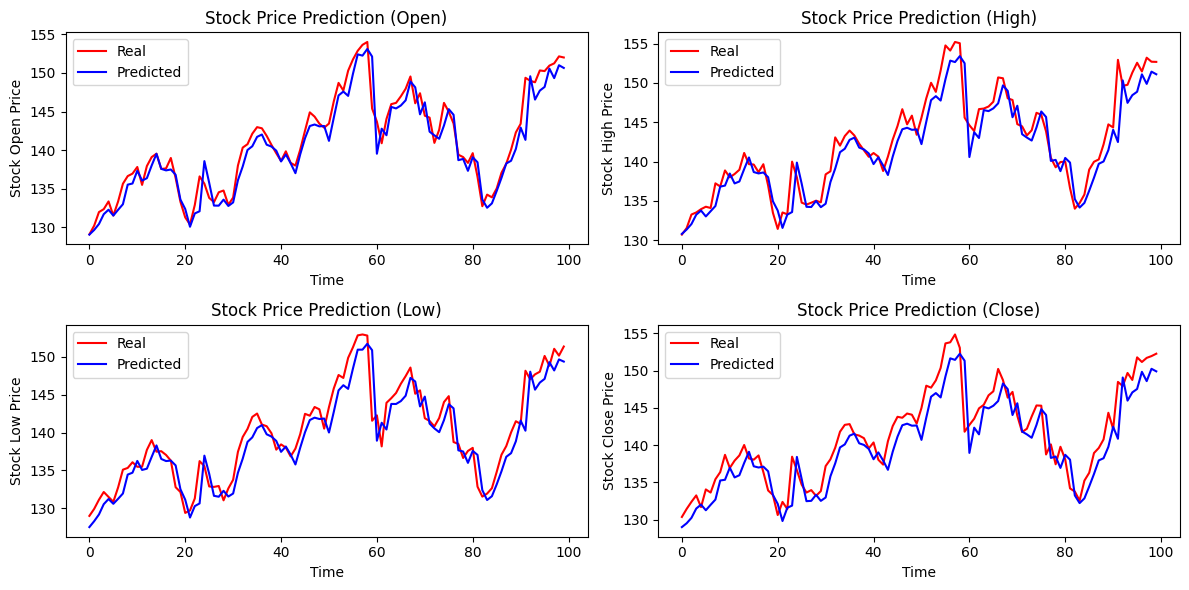

In [9]:
# covert data frame into ndarray
real_stock_price = test_data.to_numpy()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))  # Adjust figsize as needed

for i, feature in enumerate(features):
    ax = axes.flat[i]  # Get the current subplot

    # Plot actual and predicted prices for the feature
    ax.plot(real_stock_price[:, i], color='red', label='Real')
    ax.plot(predicted_stock_price[:, i], color='blue', label='Predicted')

    # Set title, labels, and legend for each subplot
    ax.set_title(f"Stock Price Prediction ({feature})")
    ax.set_xlabel('Time')
    ax.set_ylabel(f'Stock {feature} Price')
    ax.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()